In [1]:
%load_ext autoreload
%autoreload 2
import config as cfg
from sca import plots, helpers as h

In [2]:
X, y, pts, ks = h.load_data(cfg.DATA_DIR / 'ascadv_clean.h5')
fi, feat_rank = h.rf_feature_importances(X, y, pts, ks, seed=cfg.SEED)

01:55:31: [1] Mean PI: 0.002


In [3]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

pl_rf = make_pipeline(
    StandardScaler(),
    RFC(n_estimators=100, max_depth=5, min_samples_leaf=10, 
        n_jobs=-1, random_state=cfg.SEED)
)

In [4]:
import logging
import numpy as np

def rfe(model, X, y, pts, ks, remove_per_step=5, seed=cfg.SEED):
    remaining = list(range(X.shape[1]))
    removed = []
    scores = []

    base_score = h.cv(model, X, y, pts, ks, n_repeats=1, seed=seed, verbose=False)
    scores.append(base_score)
    logging.info(f"Base PI ({len(remaining)} feats): {base_score:.2e}")

    while len(remaining) > remove_per_step:
        model.fit(X[:, remaining], y)

        rf = model.named_steps['randomforestclassifier']
        importances = rf.feature_importances_

        to_remove_local = np.argsort(importances)[:remove_per_step]
        to_remove = [remaining[i] for i in to_remove_local]

        for r in to_remove:
            remaining.remove(r)
            removed.append(r)

        score = h.cv(model, X[:, remaining], y, pts, ks,
                     n_repeats=1, seed=seed, verbose=False)
        scores.append(score)
        logging.info(f"PI ({len(remaining)} feats): {score:.2e}")

    return remaining, removed, scores

remaining, removed, scores = rfe(pl_rf, X[:, feat_rank[:200]], y, pts, ks)

01:55:45: Base PI (200 feats): 5.76e-03
01:56:11: PI (195 feats): 5.56e-03
01:56:32: PI (190 feats): 5.57e-03
01:56:50: PI (185 feats): 5.54e-03
01:57:08: PI (180 feats): 5.77e-03
01:57:26: PI (175 feats): 6.41e-03
01:57:44: PI (170 feats): 6.58e-03
01:58:02: PI (165 feats): 6.63e-03
01:58:19: PI (160 feats): 5.86e-03
01:58:36: PI (155 feats): 6.38e-03
01:58:54: PI (150 feats): 6.25e-03
01:59:11: PI (145 feats): 7.45e-03
01:59:28: PI (140 feats): 7.09e-03
01:59:44: PI (135 feats): 7.14e-03
02:00:01: PI (130 feats): 7.13e-03
02:00:18: PI (125 feats): 7.34e-03
02:00:34: PI (120 feats): 6.72e-03
02:00:50: PI (115 feats): 8.16e-03
02:01:06: PI (110 feats): 7.81e-03
02:01:22: PI (105 feats): 7.86e-03
02:01:37: PI (100 feats): 8.84e-03
02:01:53: PI (95 feats): 9.39e-03
02:02:08: PI (90 feats): 9.30e-03
02:02:24: PI (85 feats): 9.25e-03
02:02:38: PI (80 feats): 9.52e-03
02:02:53: PI (75 feats): 1.04e-02
02:03:07: PI (70 feats): 1.06e-02
02:03:22: PI (65 feats): 1.13e-02
02:03:36: PI (60 feats

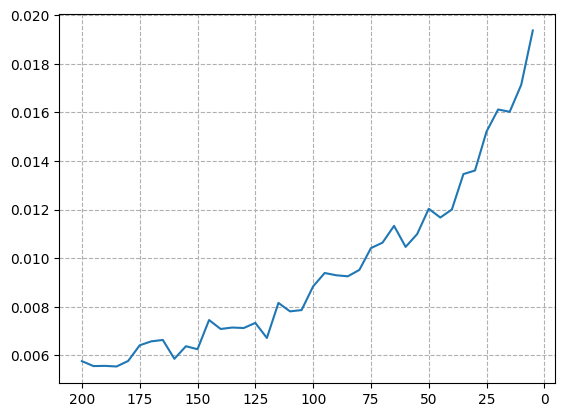

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
xaxis = np.arange(len(remaining), len(remaining) + len(removed) + 1, 5)
ax.plot(xaxis, scores[::-1])
ax.grid(True, linestyle='--')
ax.invert_xaxis()
fig.savefig("figures/rf_rfe_nfeats_vs_pi.svg")

In [10]:
feat_reranked = feat_rank[list((*remaining, *removed[::-1]))]

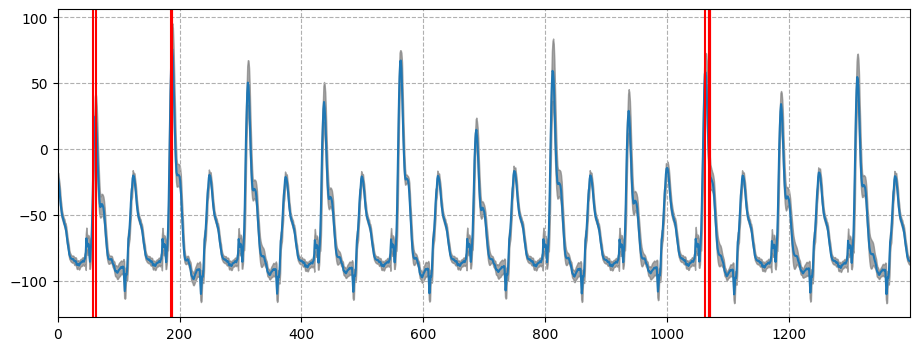

In [12]:
fig, ax = plt.subplots(figsize=(11, 4))
    
m, sd = plots.mean_std(X)
ax.plot(m, label="mean")
ax.grid(True, linestyle='--')

plots.lim(ax, len(m))
plots.std_band(ax, m, sd)

for i in feat_reranked[:10]:
    ax.axvline(i, color='r')

In [13]:
(best,), removed, _ = rfe(pl_rf, X[:, feat_reranked[:10]], y, pts, ks, remove_per_step=1)

10:34:01: Base PI (10 feats): 1.72e-02
10:34:11: PI (9 feats): 1.84e-02
10:34:21: PI (8 feats): 1.85e-02
10:34:31: PI (7 feats): 1.84e-02
10:34:41: PI (6 feats): 1.87e-02
10:34:51: PI (5 feats): 1.94e-02
10:35:00: PI (4 feats): 1.92e-02
10:35:10: PI (3 feats): 1.49e-02
10:35:19: PI (2 feats): 1.24e-02
10:35:29: PI (1 feats): -2.66e-02


In [15]:
best_feats = feat_reranked[list((best, *removed[::-1][:5]))]
np.save("data/rf_rfe_5_best.npy", best_feats)